<a href="https://colab.research.google.com/github/daniel3108-pl/TextToSpeechSystem_WaveNetBased/blob/master/WaveNetVocoderNotebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Testowy notebook do pracy nad Vocoderem WaveNet'owym

## Pobranie odpwiednich plikow do pracy

In [ ]:
# installing pytorch
! pip install torch torchvision torchaudio

In [ ]:
! curl https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2 --output ljspeech.tar.bz2

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2621M  100 2621M    0     0   158M      0  0:00:16  0:00:16 --:--:--  212M


In [ ]:
! tar -xf ljspeech.tar.bz2
! rm -rf ljspeech.tar.bz2

## Zaladowanie bibliotek

In [51]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import IPython

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio

%matplotlib inline

In [ ]:
DATASET_PATH = os.path.join(".", "LJSpeech-1.1", "wavs")

SAMPLE_WAV = os.path.join(DATASET_PATH, "LJ001-0001.wav")
SAMPLE_WAV2 = os.path.join(DATASET_PATH, "LJ001-0002.wav")

print("LJ001-0001.wav")
IPython.display.display(IPython.display.Audio(SAMPLE_WAV))
print("LJ001-0002.wav")
IPython.display.display(IPython.display.Audio(SAMPLE_WAV2))

LJ001-0001.wav


LJ001-0002.wav


In [38]:
# ladowanie danych z torchaudio

metadata = torchaudio.info(SAMPLE_WAV)

print("SAMPLE_WAV META:")
print(metadata)

SAMPLE_WAV META:
AudioMetaData(sample_rate=22050, num_frames=212893, num_channels=1, bits_per_sample=16, encoding=PCM_S)


In [ ]:
waveform, sample_rate = torchaudio.load(SAMPLE_WAV)
waveform

tensor([[-7.3242e-04, -7.6294e-04, -6.4087e-04,  ...,  7.3242e-04,
          2.1362e-04,  6.1035e-05]])

In [56]:
def show_spectogram(waveform: torch.Tensor, sample_rate, file):
    waves = waveform.numpy()

    channels, frames = waveform.shape
    time_ax = np.arange(0, frames) / sample_rate

    fig, ax = plt.subplots(channels, 1, figsize=(13, 8))
    if channels == 1:
        ax = [ax]
    for i in range(0, channels):
        ax[i].specgram(waves[i], Fs=sample_rate)
        ax[i].set_ylabel(f'Channel {i}')
    
    fig.suptitle("Spectogram for {}".format(file))
    plt.show(block=False)
    

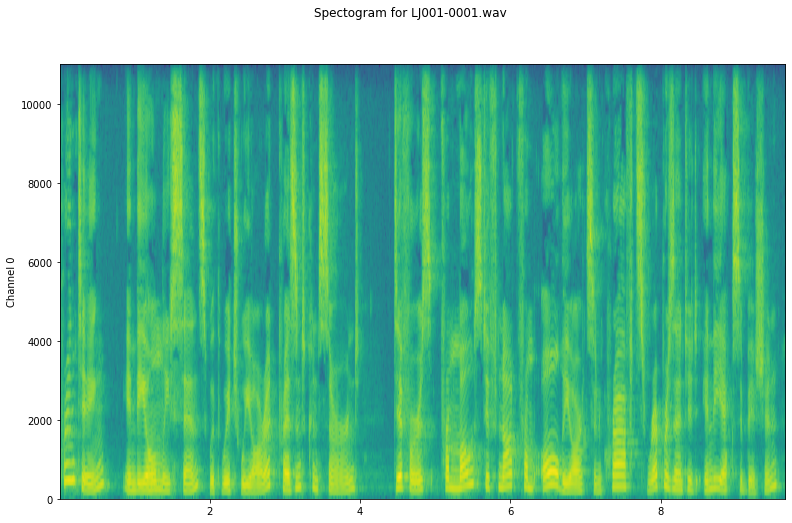

In [57]:
show_spectogram(waveform, sample_rate, "LJ001-0001.wav")

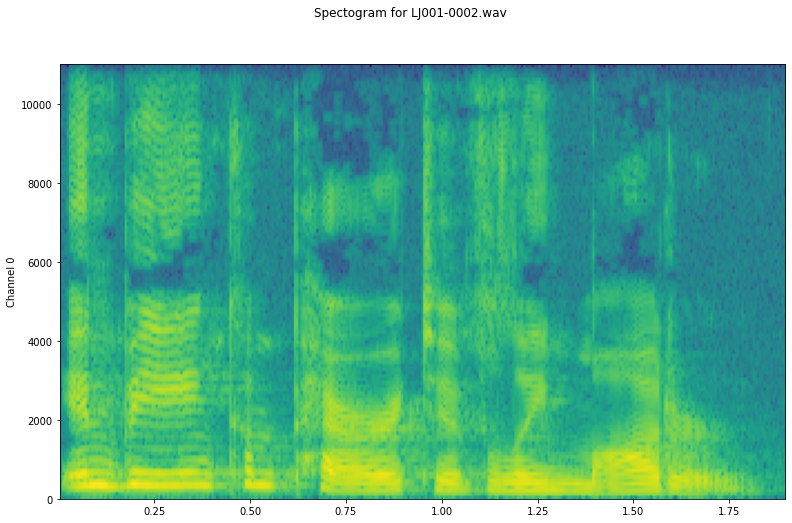

In [49]:
waveform2, sample_rate2 = torchaudio.load(SAMPLE_WAV2)

show_spectogram(waveform2, sample_rate2, "LJ001-0002.wav")


In [50]:
import torchaudio.functional as taF
import torchaudio.transforms as taT

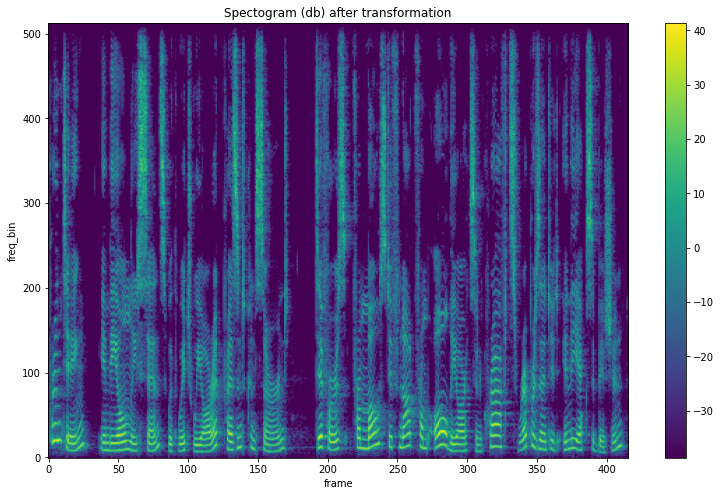

In [53]:
import librosa
# transformacja by wyciagnac frequency make-up FFT (Fast Fourier Transformation)

n_fft = 1024
win_length = None
hop_length = 512

spectogram = taT.Spectrogram(
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0
)

spec = spectogram(waveform)

fig, ax = plt.subplots(1, 1, figsize=(13,8))
ax.set_title("Spectogram (db) after transformation")
ax.set_ylabel("freq_bin")
ax.set_xlabel("frame")
im = ax.imshow(librosa.power_to_db(spec[0]), origin="lower", aspect="auto")
fig.colorbar(im, ax=ax)


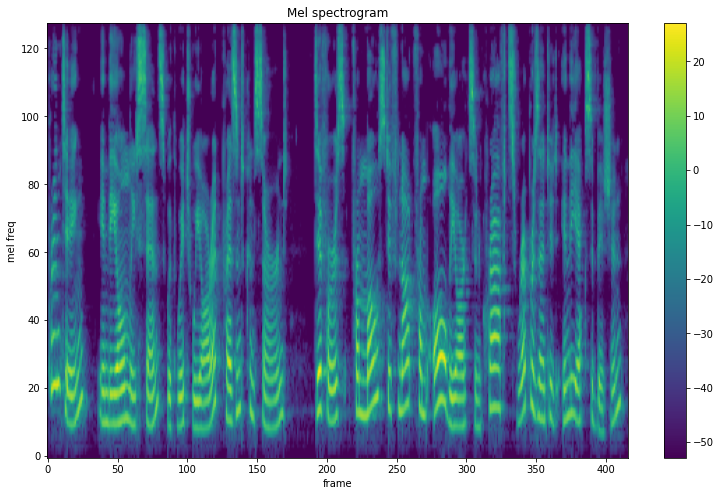

In [58]:
# uzyskanie mel spectrogramu

n_fft = 1024
win_length = None
hop_length = 512
n_mels = 128

mel_spectogram = taT.MelSpectrogram(
    sample_rate=sample_rate,
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
    norm='slaney',
    onesided=True,
    n_mels=n_mels,
    mel_scale="htk"
)

melspec = mel_spectogram(waveform)
fig, ax = plt.subplots(1, 1, figsize=(13,8))
ax.set_title("Mel spectrogram")
ax.set_ylabel("mel freq")
ax.set_xlabel("frame")
im = ax.imshow(librosa.power_to_db(melspec[0]), origin="lower", aspect="auto")
fig.colorbar(im, ax=ax)



## LJSpeech csv - eksploracja

In [60]:
! cat LJSpeech-1.1/README

-----------------------------------------------------------------------------
The LJ Speech Dataset

Version 1.0
July 5, 2017
https://keithito.com/LJ-Speech-Dataset
-----------------------------------------------------------------------------


OVERVIEW

This is a public domain speech dataset consisting of 13,100 short audio clips
of a single speaker reading passages from 7 non-fiction books. A transcription
is provided for each clip. Clips vary in length from 1 to 10 seconds and have
a total length of approximately 24 hours.

The texts were published between 1884 and 1964, and are in the public domain.
The audio was recorded in 2016-17 by the LibriVox project and is also in the
public domain.



FILE FORMAT

Metadata is provided in metadata.csv. This file consists of one record per
line, delimited by the pipe character (0x7c). The fields are:

  1. ID: this is the name of the corresponding .wav file
  2. Transcription: words spoken by the reader (UTF-8)
  3. Normalized Transcription: 

In [67]:
lj_metadata = pd.read_csv(os.path.join("LJSpeech-1.1", "metadata.csv"), header=None, error_bad_lines=False)
lj_metadata.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)
b'Skipping line 7: expected 5 fields, saw 7\nSkipping line 9: expected 5 fields, saw 7\nSkipping line 12: expected 5 fields, saw 9\nSkipping line 22: expected 5 fields, saw 7\nSkipping line 25: expected 5 fields, saw 7\nSkipping line 27: expected 5 fields, saw 7\nSkipping line 28: expected 5 fields, saw 9\nSkipping line 30: expected 5 fields, saw 7\nSkipping line 35: expected 5 fields, saw 7\nSkipping line 45: expected 5 fields, saw 7\nSkipping line 53: expected 5 fields, saw 7\nSkipping line 56: expected 5 fields, saw 7\nSkipping line 58: expected 5 fields, saw 9\nSkipping line 59: expected 5 fields, saw 7\nSkipping line 70: expected 5 fields, saw 9\nSkipping line 76: expected 5 fields, saw 13\nSkipping line 84: expected 5 fields, saw 7\nSkipping line 

,0,1,2,3,4
0,LJ001-0001|Printing,in the only sense with which we are at presen...,differs from most if not from all the arts an...,in the only sense with which we are at presen...,differs from most if not from all the arts an...
1,LJ001-0002|in being comparatively modern.|in b...,NaN,NaN,NaN,NaN
2,LJ001-0003|For although the Chinese took impre...,by a similar process|For although the Chinese...,by a similar process,NaN,NaN
3,LJ001-0004|produced the block books,which were the immediate predecessors of the ...,|produced the block books,which were the immediate predecessors of the ...,NaN
4,LJ001-0005|the invention of movable metal lett...,NaN,NaN,NaN,NaN


In [69]:
! head -n 5 LJSpeech-1.1/metadata.csv

LJ001-0001|Printing, in the only sense with which we are at present concerned, differs from most if not from all the arts and crafts represented in the Exhibition|Printing, in the only sense with which we are at present concerned, differs from most if not from all the arts and crafts represented in the Exhibition
LJ001-0002|in being comparatively modern.|in being comparatively modern.
LJ001-0003|For although the Chinese took impressions from wood blocks engraved in relief for centuries before the woodcutters of the Netherlands, by a similar process|For although the Chinese took impressions from wood blocks engraved in relief for centuries before the woodcutters of the Netherlands, by a similar process
LJ001-0004|produced the block books, which were the immediate predecessors of the true printed book,|produced the block books, which were the immediate predecessors of the true printed book,
LJ001-0005|the invention of movable metal letters in the middle of the fifteenth century may justl

In [70]:
lj_metadata = pd.read_csv(os.path.join("LJSpeech-1.1", "metadata.csv"), sep="|", header=None, error_bad_lines=False)
lj_metadata.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


,0,1,2
0,LJ001-0001,"Printing, in the only sense with which we are ...","Printing, in the only sense with which we are ..."
1,LJ001-0002,in being comparatively modern.,in being comparatively modern.
2,LJ001-0003,For although the Chinese took impressions from...,For although the Chinese took impressions from...
3,LJ001-0004,"produced the block books, which were the immed...","produced the block books, which were the immed..."
4,LJ001-0005,the invention of movable metal letters in the ...,the invention of movable metal letters in the ...


In [78]:
lj_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13100 entries, 0 to 13099
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       13100 non-null  object
 1   1       13100 non-null  object
 2   2       13084 non-null  object
dtypes: object(3)
memory usage: 307.2+ KB


In [77]:
lj_metadata.iloc[:, 2] == lj_metadata.iloc[:, 1]

0        True
1        True
2        True
3        True
4        True
         ... 
13095    True
13096    True
13097    True
13098    True
13099    True
Length: 13100, dtype: bool

In [76]:
lj_metadata[lj_metadata.iloc[:, 2] != lj_metadata.iloc[:, 1]]

,0,1,2
6,LJ001-0007,"the earliest book printed with movable types, ...","the earliest book printed with movable types, ..."
23,LJ001-0024,But the first Bible actually dated (which also...,But the first Bible actually dated (which also...
30,LJ001-0031,In 1465 Sweynheim and Pannartz began printing ...,In fourteen sixty-five Sweynheim and Pannartz ...
33,LJ001-0034,"They printed very few books in this type, thre...","They printed very few books in this type, thre..."
37,LJ001-0038,while in 1470 at Paris Udalric Gering and his ...,while in fourteen seventy at Paris Udalric Ger...
...,...,...,...
13057,LJ050-0236,"Thus, in the 4 months following the assassinat...","Thus, in the four months following the assassi..."
13058,LJ050-0237,"the FBI, on 16 separate occasions, supplied a ...","the FBI, on sixteen separate occasions, suppli..."
13060,LJ050-0239,"From February 11 through June 30, 1964,","From February eleven through June thirty, nine..."
13061,LJ050-0240,"the Service had the advantage of 9,500 hours o...",the Service had the advantage of nine thousand...


In [80]:
lj_metadata[lj_metadata.iloc[:, 2].isna()]

,0,1,2
945,LJ004-0076,"Disease, cold, famine, nakedness, and contagio...",NaN
948,LJ004-0079,All measures and practices in prison which may...,NaN
1119,LJ004-0250,It is obvious that reformation must be materia...,NaN
1147,LJ005-0028,"There should be no tea and sugar, no assemblag...",NaN
1149,LJ005-0030,"In prisons, which are really meant to keep the...",NaN
1196,LJ005-0077,expedient to introduce such measures and arran...,NaN
1371,LJ005-0253,to inquire into and report upon the several ja...,NaN
1400,LJ005-0282,"the comparatively innocent are seduced, the un...",NaN
1500,LJ006-0083,"So great is the authority exercised by him,|So...",NaN
1655,LJ006-0238,There was a disturbance in the transport yard ...,NaN


In [89]:
condition = lj_metadata.iloc[:, 2].isna()
lj_metadata.loc[condition, 2] = lj_metadata.loc[condition].iloc[:, 1] \
                                          .apply(lambda x: str(x).split("|")[1])

In [90]:
lj_metadata[condition]

,0,1,2
945,LJ004-0076,"Disease, cold, famine, nakedness, and contagio...","Disease, cold, famine, nakedness, and contagio..."
948,LJ004-0079,All measures and practices in prison which may...,All measures and practices in prison which may...
1119,LJ004-0250,It is obvious that reformation must be materia...,It is obvious that reformation must be materia...
1147,LJ005-0028,"There should be no tea and sugar, no assemblag...","There should be no tea and sugar, no assemblag..."
1149,LJ005-0030,"In prisons, which are really meant to keep the...","In prisons, which are really meant to keep the..."
1196,LJ005-0077,expedient to introduce such measures and arran...,expedient to introduce such measures and arran...
1371,LJ005-0253,to inquire into and report upon the several ja...,to inquire into and report upon the several ja...
1400,LJ005-0282,"the comparatively innocent are seduced, the un...","the comparatively innocent are seduced, the un..."
1500,LJ006-0083,"So great is the authority exercised by him,|So...","So great is the authority exercised by him,"
1655,LJ006-0238,There was a disturbance in the transport yard ...,There was a disturbance in the transport yard ...


In [92]:
lj_metadata.loc[condition, 1] = lj_metadata.loc[condition].iloc[:, 1] \
                                          .apply(lambda x: str(x).split("|")[0])

In [94]:
lj_metadata.loc[condition] 

,0,1,2
945,LJ004-0076,"Disease, cold, famine, nakedness, and contagio...","Disease, cold, famine, nakedness, and contagio..."
948,LJ004-0079,All measures and practices in prison which may...,All measures and practices in prison which may...
1119,LJ004-0250,It is obvious that reformation must be materia...,It is obvious that reformation must be materia...
1147,LJ005-0028,"There should be no tea and sugar, no assemblag...","There should be no tea and sugar, no assemblag..."
1149,LJ005-0030,"In prisons, which are really meant to keep the...","In prisons, which are really meant to keep the..."
1196,LJ005-0077,expedient to introduce such measures and arran...,expedient to introduce such measures and arran...
1371,LJ005-0253,to inquire into and report upon the several ja...,to inquire into and report upon the several ja...
1400,LJ005-0282,"the comparatively innocent are seduced, the un...","the comparatively innocent are seduced, the un..."
1500,LJ006-0083,"So great is the authority exercised by him,","So great is the authority exercised by him,"
1655,LJ006-0238,There was a disturbance in the transport yard ...,There was a disturbance in the transport yard ...


In [97]:
lj_metadata.to_csv("LJSpeech-1.1/metadata_f.csv", header=None, sep="\t", index=None)

In [98]:
! head -n 5 LJSpeech-1.1/metadata_f.csv

LJ001-0001	Printing, in the only sense with which we are at present concerned, differs from most if not from all the arts and crafts represented in the Exhibition	Printing, in the only sense with which we are at present concerned, differs from most if not from all the arts and crafts represented in the Exhibition
LJ001-0002	in being comparatively modern.	in being comparatively modern.
LJ001-0003	For although the Chinese took impressions from wood blocks engraved in relief for centuries before the woodcutters of the Netherlands, by a similar process	For although the Chinese took impressions from wood blocks engraved in relief for centuries before the woodcutters of the Netherlands, by a similar process
LJ001-0004	produced the block books, which were the immediate predecessors of the true printed book,	produced the block books, which were the immediate predecessors of the true printed book,
LJ001-0005	the invention of movable metal letters in the middle of the fifteenth century may justl